In [6]:
import re

phom = 'benchmark/Methods_benchmarking_pairs/pfam_hom-pairs_nomax50.txt'
pnon = 'benchmark/Methods_benchmarking_pairs/pfam_nonhom-pairs_nomax50.txt'
ghom = 'benchmark/Methods_benchmarking_pairs/gene3d_hom-pairs_nomax50.txt'
gnon = 'benchmark/Methods_benchmarking_pairs/gene3d_nonhom-pairs_nomax50.txt'
shom = 'benchmark/Methods_benchmarking_pairs/supfam_hom-pairs_nomax50.txt'
snon = 'benchmark/Methods_benchmarking_pairs/supfam_nonhom-pairs_nomax50.txt'

def read_benchmark_pairs(filepath,isHomolog):
    pairs = list()
    with open(filepath,'r') as f:
        for line in f:
            pair = []
            for searchResult in re.finditer('[@_]([A-Za-z]\d[A-Z\d]+)',line):
                res = searchResult.groups()[0]
                pair.append(res)
            pairs.append((pair[0],pair[1],isHomolog))
    return pairs

phoml = read_benchmark_pairs(phom,1)
pnonl = read_benchmark_pairs(pnon,0)
ghoml = read_benchmark_pairs(ghom,1)
gnonl = read_benchmark_pairs(gnon,0)
shoml = read_benchmark_pairs(shom,1)
snonl = read_benchmark_pairs(snon,0)

#TODO
#find unique uniprot ID
#do we have it swissprot db?
#if we don't download them
#get all sequences
#embed them all using gpu
#calculate prost distance
#write out the results

In [3]:
print(len(phoml),len(pnonl),len(ghoml),len(gnonl),len(shoml),len(snonl))

36401 36401 29131 29131 24751 24751


In [10]:
import numpy as np
unipIDs = set()
unipIDs.update(np.array(phoml)[:,0].tolist())
unipIDs.update(np.array(phoml)[:,1].tolist())
unipIDs.update(np.array(pnonl)[:,0].tolist())
unipIDs.update(np.array(pnonl)[:,1].tolist())

unipIDs.update(np.array(ghoml)[:,0].tolist())
unipIDs.update(np.array(ghoml)[:,1].tolist())
unipIDs.update(np.array(gnonl)[:,0].tolist())
unipIDs.update(np.array(gnonl)[:,1].tolist())

unipIDs.update(np.array(shoml)[:,0].tolist())
unipIDs.update(np.array(shoml)[:,1].tolist())
unipIDs.update(np.array(snonl)[:,0].tolist())
unipIDs.update(np.array(snonl)[:,1].tolist())

print(len(unipIDs))

18899


In [14]:
from contactGroups import commp as cp
from pickle import load,dump

spe = {}
for f in cp.fasta_iter('data/spe.fa'):
    name = f[0].split('|')[1]
    spe[name] = f[1]
    
with open('data/spe.pkl','wb') as f:
    dump(spe,f)

In [19]:
with open('data/spe.pkl','rb') as f:
    spe = load(f)
print(len(spe))

565939


In [15]:
download = []
for p in unipIDs:
    if p not in spe: download.append(p)
print(len(download),download[:5])

17 ['P30512', 'P91301', 'P15092', 'Q8RVQ5', 'Q6ZRR9']


In [23]:
import urllib.request
import re

for p in download:
    if p in spe: continue
    with urllib.request.urlopen('https://rest.uniprot.org/unisave/%s?format=fasta'%p) as f:
        fasta = f.read().decode('utf-8')
        lines = fasta.splitlines()
        if len(lines) < 2:
            print(p,lines)
            continue
        results = re.search('\|([\w\d]+)\|',lines[0]).groups()
        if len(results) >= 1:
            protname = results[0]
            print(p,protname)
        else:
            protname = p
            print(p,lines[0])
        seq = ''
        for l in lines[1:]: 
            if l.startswith('>'): break
            seq += l
        spe[p] = seq

In [24]:
with open('data/spe.pkl','wb') as f:
    dump(spe,f)

In [25]:
with open('benchmark/nomax.fa', 'w') as f:
    for p in unipIDs:
        f.write('>%s\n%s\n'%(p,spe[p]))
    

In [5]:
!prost makedb benchmark/nomax.fa benchmark/nomax.prdb

P30512 not found in cache. Quantize it.
P91301 not found in cache. Quantize it.
P15092 not found in cache. Quantize it.
Q6ZRR9 not found in cache. Quantize it.
Q3BBV1 not found in cache. Quantize it.
P29020 not found in cache. Quantize it.
A6NKF9 not found in cache. Quantize it.
Q09160 not found in cache. Quantize it.
Q9VQE7 not found in cache. Quantize it.
Q80Z60 not found in cache. Quantize it.
A8MT82 not found in cache. Quantize it.
Q14591 not found in cache. Quantize it.
P34265 not found in cache. Quantize it.
Total number of sequences embedded in the db: 18899


In [9]:
from pickle import load,loads,dump,dumps
import blosc

with open('benchmark/nomax.prdb','rb') as f:
    qnames,qdb = loads(blosc.decompress(f.read()))
    
db50 = {}
for i in range(len(qnames)):
    db50[qnames[i]] = qdb[i]

In [8]:
def predict(l):
    r = []
    p = []
    for p1,p2,real in l:
        dist = abs(db50[p1]-db50[p2]).sum()/2
        r.append(real)
        p.append(-dist)
    return p,r
        

In [4]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score
from sklearn.metrics import precision_recall_curve, auc

def predictAll(dbname):
    if dbname == 'pfam': l1 = phoml; l2 = pnonl
    elif dbname == 'gene3d': l1 = ghoml; l2 = gnonl
    else: l1 = shoml; l2 = snonl
    ph,rh = predict(l1)
    pn,rn = predict(l2)
    p = ph+pn
    r = rh+rn
    return p,r

def aucNth(y, yp, N):
    assert len(y) == len(yp)
    assert len(y) > 1
    fpr, tpr, thresholds = roc_curve(y, yp)
    negatives = y.count(0)
    assert N < negatives
    perc = N / float(negatives)
    fpr1k = []
    tpr1k = []
    i = 0
    while i < len(fpr):
        if fpr[i] > perc:
            break
        fpr1k.append(fpr[i])
        tpr1k.append(tpr[i])
        i+=1
    assert len(fpr1k) > 1
    aucScore = auc(fpr1k, tpr1k) / perc
    return aucScore

def score(dbname):
    p,r = predictAll(dbname)
    fpr, tpr, threshold = roc_curve(r, p)
    aucp = aucNth(r, p, 10000)
    aucScore = roc_auc_score(r,p)
    return fpr,tpr,aucScore,aucp

In [80]:

print(score('pfam')[2:])
print(score('supfam')[2:])
print(score('gene3d')[2:])

(0.9544024155821634, 0.9172815238592347)
(0.8968168826323728, 0.8315574946466809)
(0.8761698319457669, 0.7944259105420344)


In [3]:
def load_benchmark(method,db,max50=True,N=1000):
    if max50: path = 'benchmark/Bitscores_and_Evalues/ROC_plot_Bitscores_max50_1vs1_rank/'+method+'_'+db+'_max50_1vs1'
    else: path = 'benchmark/Bitscores_and_Evalues/ROC_plot_Bitscores_nomax50_1vs1_rank/'+method+'_'+db+'_nomax50_1vs1'
    sens = []
    spec = []
    at = []
    af = []
    with open(path,'r') as f:
        for line in f:
            line = line.strip().split()
            t = float(line[0])
            f = float(line[1])
            sens.append(t)
            spec.append(f)
            if f <= N:
                at.append(t)
                af.append(f)
    cnt = (len(sens)+1)/2
    sens = np.array(sens)/cnt
    spec = np.array(spec)/cnt
    at = np.array(at)/cnt
    af = np.array(af)/cnt
    aucScore = auc(spec,sens)
    aucN = auc(af,at)/(N/cnt)
    return spec,sens,aucScore,aucN

In [16]:
print(load_benchmark('blast','pfam')[2:])
print(load_benchmark('blast','supfam')[2:])
print(load_benchmark('blast','gene3d')[2:])

(0.9590403134857203, 0.9090149666348905)
(0.9343951676904034, 0.8574341192787795)
(0.9410576056469053, 0.8788796852899576)


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pickle

def load_pickle(fname):
    with open(fname,'rb') as f:
        return pickle.load(f)

def plot(db):

    if db == 'pfam': 
        methods = ["phmmer","PROST-L","csblast","hhsearch","blast","PROST","usearch","fasta","ublast","ESM1bL34M"]
        colors = ["#EEAD0E","r--","#D95F0E","#4DAC26","#92C5DE",'r',"#636363","#D01C8B","#0eeead",'black']
        title = 'PFAM'
        esmPath = 'ESM1bL34M/pfam.no50.res.pkl'
        prostLPath = 'prost-l/pfam.no50.res.pkl'
    elif db == 'gene3d':
        methods = ["phmmer","csblast","PROST-L","hhsearch","blast","PROST","usearch","fasta","ublast","ESM1bL34M"]
        colors = ["#EEAD0E","#D95F0E","r--","#4DAC26","#92C5DE",'r',"#636363","#D01C8B","#0eeead",'black']
        title = 'CATH/Gene3D'
        esmPath = 'ESM1bL34M/gene3d.no50.res.pkl'
        prostLPath = 'prost-l/gene3d.no50.res.pkl'
    else: 
        methods = ["PROST-L","phmmer","csblast","hhsearch","blast","PROST","usearch","fasta","ublast","ESM1bL34M"]
        colors = ["r--","#EEAD0E","#D95F0E","#4DAC26","#92C5DE",'r',"#636363","#D01C8B","#0eeead",'black']
        title = 'SCOP/Superfamiliy'
        esmPath = 'ESM1bL34M/supfam.no50.res.pkl'
        prostLPath = 'prost-l/supfam.no50.res.pkl'
    
    plt.title(title+' nomax50')
    with open('benchmark/figs/%s.nomax.txt'%db, 'w') as f:
        for i,m in enumerate(methods):
            if m == 'PROST-L':
                fpr,tpr,aucScore,aucp = load_pickle(prostLPath)
            elif m == 'PROST':
                pr,r = predictAll(db)
                fpr, tpr, threshold = roc_curve(r, pr)
                aucScore = roc_auc_score(r,pr)
                aucp = aucNth(r, pr, 10000)
            elif m == 'ESM1bL34M':
                fpr,tpr,aucScore,aucp = load_pickle(esmPath)
            else:
                fpr,tpr,aucScore,aucp = load_benchmark(m,db,False,10000)
                
            plt.plot(fpr, tpr, colors[i], label = '%s = %4.1f' % (m.upper().ljust(10),aucp*100))
            f.write('%s\t%.4f\t%.4f\n'%(m.upper(),aucScore,aucp))
            
    plt.legend(loc = 'lower right',title='Search Tools AUC10000 Scores',prop=matplotlib.font_manager.FontProperties(family='monospace'))
    plt.plot([0, 1], [0, 1],'b--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig('benchmark/figs/%s.nomax.png'%db, dpi=600)
    plt.savefig('benchmark/figs/%s.nomax.svg'%db)
    plt.show()

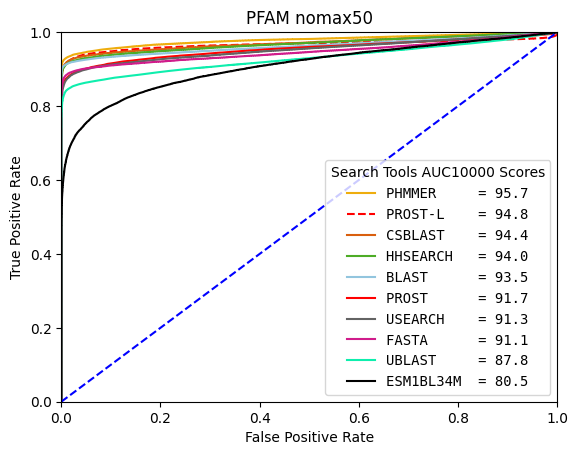

In [10]:
plot('pfam')

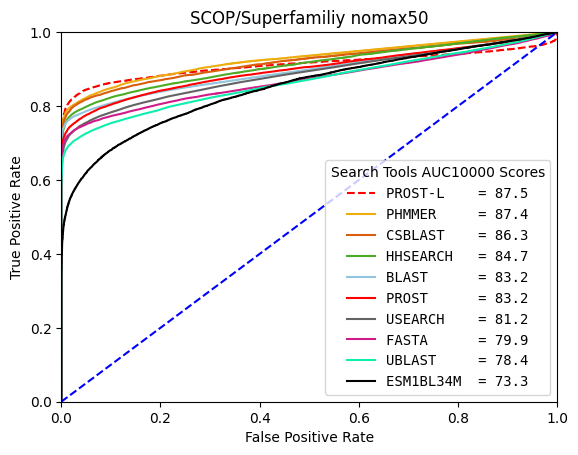

In [11]:
plot('supfam')

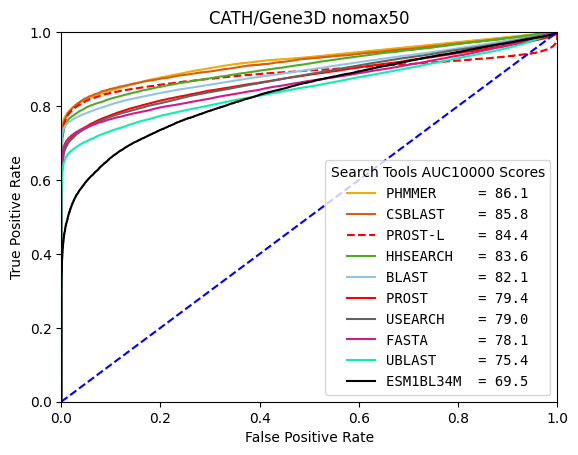

In [12]:
plot('gene3d')